In [28]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/tp2datostrain/train.csv
/kaggle/input/tp2datostrain/test.csv
/kaggle/input/skipcell/skip-cell.py
/kaggle/input/pingsound/PING - Sound effect.mp3


In [29]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from IPython.display import Audio
sound_file = '/kaggle/input/pingsound/PING - Sound effect.mp3'

In [82]:
test = pd.read_csv("../input/tp2datostrain/test.csv")
display(test.shape)
train = pd.read_csv("../input/tp2datostrain/train.csv")
display(train.shape)

(60000, 22)

(240000, 23)

In [134]:
#Elijo si voy a hacer train o test!
TRAIN = True
CV = True and TRAIN

# Arreglo el DF

In [135]:
df = train if TRAIN else test
df["fecha"] = pd.to_datetime(df["fecha"])

In [136]:
#RELLENO LOS IDS CON LO QUE MAS APARECE EN LA CIUDAD
def obtenerMasFrecuente(x):
    x = pd.Series.mode(x)
    s = x.loc[x>0]
    if len(s.index)<=0:
        return np.nan
    return s.value_counts().index[0]
print("Nulos idzona: ", df["idzona"].isna().value_counts())
print("Nulos coidad: ", df["ciudad"].isna().value_counts())

aux = df[["ciudad", "idzona"]].copy()
aux["ciudad"].fillna("dummy", inplace=True)
#aux["idzona"].fillna(-1, inplace=True)
idzonaMasFrecuentePorCiudad = aux.groupby('ciudad')["idzona"].transform(lambda x: obtenerMasFrecuente(x))
idzonaMasFrecuentePorCiudad

Nulos idzona:  False    239521
Name: idzona, dtype: int64
Nulos coidad:  False    239521
Name: ciudad, dtype: int64


0         50003995.0
1            24481.0
2            48638.0
3            53666.0
4            47735.0
             ...    
239995       53666.0
239996       51929.0
239997    50003995.0
239998       24448.0
239999       23734.0
Name: idzona, Length: 239521, dtype: float64

In [137]:
df.idzona.fillna(idzonaMasFrecuentePorCiudad, inplace = True)
print("Nulos idzona: ", df["idzona"].isna().value_counts())
#DROPEO LAS COLUMNAS QUE QUEDARON SIN NADA
df.dropna(subset=['idzona'], inplace = True)
print("Nulos idzona: ", df["idzona"].isnull().value_counts())
df.shape

Nulos idzona:  False    239521
Name: idzona, dtype: int64
Nulos idzona:  False    239521
Name: idzona, dtype: int64


(239521, 24)

In [138]:
def rellenar_con_X_por_grupo(df, grupo, rellenar, func):
    valoresAgrupados = df.groupby(grupo)[rellenar].transform(func)
    df[rellenar].fillna(valoresAgrupados, inplace=True)

In [ ]:
#Reemplazo las habitaciones por la mediana de la zona
print("Nulos habitaciones: ", df["habitaciones"].isnull().value_counts())
rellenar_con_X_por_grupo(df, "idzona", "habitaciones", lambda x: x.median())
print("Nulos habitaciones: ", df["habitaciones"].isnull().value_counts())
#Relleno el resto con las mas frecuentes
df['habitaciones'] = SimpleImputer(strategy='most_frequent').fit_transform(df[['habitaciones']])
#Para la antiguedad relleno con el promedio de la zona
print("Nulos antiguedad: ", df["antiguedad"].isna().value_counts())
medianaAntiguedadXZona = df.groupby("idzona")["antiguedad"].transform(lambda x: x.median())
df["antiguedad"].fillna(medianaAntiguedadXZona, inplace = True)
print("Nulos antiguedad: ", df["antiguedad"].isna().value_counts())
#Reemplazo los banos por 1 que es lo minimo posible
df.banos.fillna(1, inplace=True)
#Relleno garages con 0 porque es lo mas probable
df.garages.fillna(0, inplace = True)
print("Nulos metrostotales: ", df["metrostotales"].isna().value_counts())
print("Nulos metroscubiertos: ", df["metroscubiertos"].isna().value_counts())
#COMO QUEDAN NULOS LOS RELLENO CON la mediana (porque la mediana es un valor, y es menos sensible a valores extremos) por ZONA / CIUDAD
promedioMetrosCubiertosXZona = df.groupby("idzona")["metroscubiertos"].transform(lambda x: x.median())
df["metroscubiertos"].fillna(promedioMetrosCubiertosXZona, inplace = True)
print("Nulos metroscubiertos: ", df["metroscubiertos"].isna().value_counts())
promedioMetrosTotalesXZona = df.groupby("idzona")["metrostotales"].transform(lambda x: x.median())
df["metrostotales"].fillna(promedioMetrosCubiertosXZona, inplace = True)
print("Nulos metrostotales: ", df["metrostotales"].isna().value_counts())

Nulos habitaciones:  False    217110
True      22411
Name: habitaciones, dtype: int64
Nulos habitaciones:  False    238267
True       1254
Name: habitaciones, dtype: int64
Nulos antiguedad:  False    196234
True      43287
Name: antiguedad, dtype: int64


In [ ]:
df["swapear"] = df["metrostotales"] < df["metroscubiertos"]
df_metros_arreglados = df.copy()
aux = df_metros_arreglados.loc[df_metros_arreglados["swapear"], "metrostotales"]
if (not aux.empty):
    df_metros_arreglados.loc[df_metros_arreglados["swapear"],"metrostotales"] = \
    df_metros_arreglados.loc[df_metros_arreglados["swapear"], "metroscubiertos"]
    df_metros_arreglados.loc[df_metros_arreglados["swapear"], "metroscubiertos"] = aux
df_metros_arreglados.drop(columns="swapear", inplace=True)
(df_metros_arreglados["metrostotales"] < df_metros_arreglados["metroscubiertos"]).value_counts()
df = df_metros_arreglados

In [ ]:
df.garages.fillna(0, inplace = True)

In [ ]:
df["nro_publicaciones_dia"] = df.groupby(pd.Grouper(key='fecha', freq='D'))["id"].transform(lambda x: len(x.index))
df["nro_publicaciones_semana"] = df.groupby(pd.Grouper(key='fecha', freq='W'))["id"].transform(lambda x: len(x.index))
df["nro_publicaciones_5_dias_habiles"] = df.groupby(pd.Grouper(key='fecha', freq='B'))["id"].transform(lambda x: len(x.index))
df["nro_publicaciones_mes"] = df.groupby(pd.Grouper(key='fecha', freq='M'))["id"].transform(lambda x: len(x.index))

In [ ]:
df.head()

# Preprocesador

In [ ]:
features = ['idzona',
            "metrostotales", "metroscubiertos", 
            'garages',
            'gimnasio','centroscomercialescercanos','usosmultiples','piscina','escuelascercanas',
            'nro_publicaciones_dia',
            'nro_publicaciones_semana',
            'nro_publicaciones_5_dias_habiles',
            'nro_publicaciones_mes',
            'antiguedad',
            'habitaciones',
            ]

In [ ]:
transformador_categorias = make_pipeline(SimpleImputer(strategy='most_frequent'),
                                         OneHotEncoder(handle_unknown='ignore'))

transformador_numeros = make_pipeline(SimpleImputer())

In [ ]:
def obtenerFeaturesCategoricos(features):
    l = []
    for feature in features:
        if not np.issubdtype(df[feature].dtype, np.number):
            l.append(feature)
    return l

num_features = list(df[features].select_dtypes(include=[np.number]).columns)

cat_features = list(obtenerFeaturesCategoricos(features))
print ("Features numericos:", num_features, '\nFeatures categoricos: ', cat_features)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', transformador_numeros, num_features),
        ('cat', transformador_categorias, cat_features)
    ])

In [ ]:
model = xgb.XGBRegressor( n_estimators=200, learning_rate=0.1, max_depth=5, subsample_by_tree=0.5,
                         colsample_by_col=0.5, min_child_weight=8,
                     colsample_bytree = 0.6, x_gamma = 0.47299983077893815,
                     x_reg_lambda = 0.12707727377560518, x_subsample = 0.7361630765924525,
                     objective='reg:squarederror',
                     #early_stopping_rounds=10,
                     tree_method='gpu_hist', gpu_id=0) if TRAIN else model

# Lo entreno

In [127]:
y = df.precio.copy() if TRAIN else None

X = df[features].copy()
if CV:
    Xaux, Txaux, yaux, Tyaux = train_test_split(X, y,train_size=0.8, test_size=0.2, random_state = 0)
X = Xaux if CV else X
y = yaux if CV else y
Tx = Txaux if CV else None
Ty = Tyaux if CV else None

In [128]:
if (TRAIN):
    nuevo_pipeline = make_pipeline(preprocessor, model, verbose = True)
    nuevo_pipeline.fit(X, y)
else:
    nuevo_pipeline = pipeline
pipeline = nuevo_pipeline
#model.get_booster().feature_names = features

[Pipeline] . (step 1 of 2) Processing columntransformer, total=   0.1s


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[Pipeline] ...... (step 2 of 2) Processing xgbregressor, total=   1.0s


In [129]:
Tx = Tx if (TRAIN and CV) else X #Si estoy en TRAIN y con Cross Validatrion uso el Tx que ya armé. Sino el X entero
predicciones = pipeline.predict(Tx)

In [130]:
if (TRAIN):
    Ty = Ty if CV else y
    print("MAE XGBoost: ", mean_absolute_error(Ty, predicciones))

MAE XGBoost:  742688.9649998206


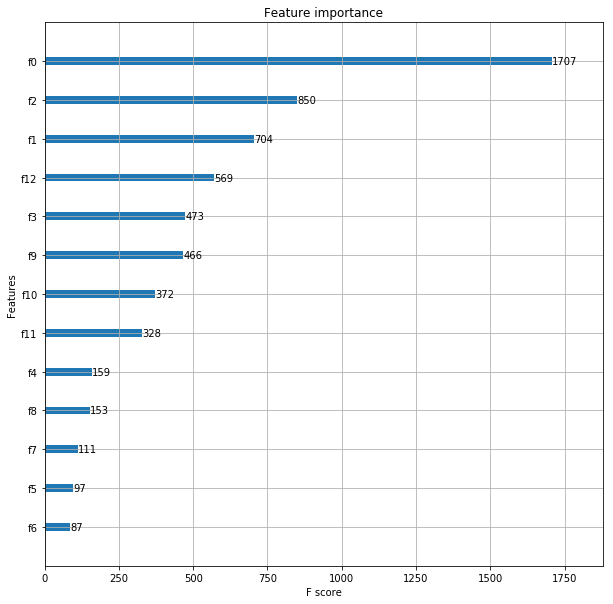

In [131]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1,figsize=(10,10))
xgb.plot_importance(model.get_booster(), ax = ax)
#for col,score in zip(X.columns,model.feature_importances_):    print(col,score)

In [48]:
Audio(sound_file, autoplay=True)

In [49]:
res = pd.DataFrame(predicciones, index=test.id, columns=['precio'])
res.reset_index(inplace=True)
res.columns = ["id", "target"]
display(res.head())
# RMSLE=1.0249284784393988 ?


# import the modules we'll need
from IPython.display import HTML
import base64

# function that takes in a dataframe and creates a text link to  
# download it (will only work for files < 2MB or so)
def create_download_link(df, title = "Download CSV file", filename = "resultados.csv"):  
    csv = df.to_csv(index=False)
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

# create a link to download the dataframe
create_download_link(res)

ValueError: Shape of passed values is (239521, 1), indices imply (60000, 1)

In [132]:
from sklearn.metrics import accuracy_score
pipeline.fit(X,y, xgbregressor__eval_set=[(X.as_matrix(), y.as_matrix()), (Tx.as_matrix(), Ty.as_matrix())])
preds = pipeline.predict(Tx)
predictions = [round(value) for value in preds]
# evaluate predictions
accuracy = accuracy_score(Ty, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[Pipeline] . (step 1 of 2) Processing columntransformer, total=   0.1s
[0]	validation_0-rmse:3.05917e+06	validation_1-rmse:3.05138e+06
[1]	validation_0-rmse:2.82045e+06	validation_1-rmse:2.81336e+06
[2]	validation_0-rmse:2.66852e+06	validation_1-rmse:2.66153e+06
[3]	validation_0-rmse:2.50934e+06	validation_1-rmse:2.50265e+06
[4]	validation_0-rmse:2.35058e+06	validation_1-rmse:2.34354e+06
[5]	validation_0-rmse:2.23111e+06	validation_1-rmse:2.22417e+06
[6]	validation_0-rmse:2.12917e+06	validation_1-rmse:2.12283e+06
[7]	validation_0-rmse:2.0231e+06	validation_1-rmse:2.01763e+06
[8]	validation_0-rmse:1.96092e+06	validation_1-rmse:1.95562e+06
[9]	validation_0-rmse:1.88052e+06	validation_1-rmse:1.87508e+06
[10]	validation_0-rmse:1.82691e+06	validation_1-rmse:1.82218e+06
[11]	validation_0-rmse:1.77857e+06	validation_1-rmse:1.77423e+06
[12]	validation_0-rmse:1.72278e+06	validation_1-rmse:1.71953e+06
[13]	validation_0-rmse:1.68352e+06	validation_1-rmse:1.68045e+06
[14]	validation_0-rmse:1.6437e

"\nfig, ax = pyplot.subplots()\nax.plot(x_axis, results['validation_0']['error'], label='Train')\nax.plot(x_axis, results['validation_1']['error'], label='Test')\nax.legend()\npyplot.ylabel('Classification Error')\npyplot.title('XGBoost Classification Error')\npyplot.show()\n"

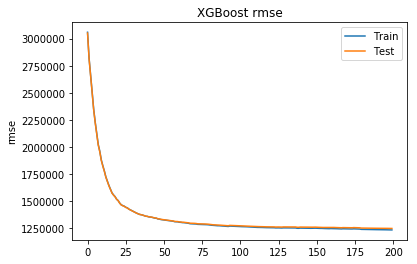

In [133]:
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
plt.ylabel('rmse')
plt.title('XGBoost rmse')
# plot classification error
"""
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()
"""

In [55]:
"""
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
param_grid = dict(xgbregressor__learning_rate=learning_rate)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(pipeline, param_grid, scoring="neg_mean_absolute_error", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X, y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score'] *-1
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))
# plot
plt.errorbar(learning_rate, means, yerr=stds)
plt.title("XGBoost learning_rate vs Squared error")
plt.xlabel('learning_rate')
plt.ylabel('Squared error')
"""

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


[Pipeline] . (step 1 of 2) Processing columntransformer, total=   0.1s


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[Pipeline] ...... (step 2 of 2) Processing xgbregressor, total=   8.7s
Best: -692115.603669 using {'xgbregressor__learning_rate': 0.1}
-2074028.159496 (5599.137814) with: {'xgbregressor__learning_rate': 0.0001}
-913110.556678 (3414.493774) with: {'xgbregressor__learning_rate': 0.001}
-739760.306702 (4107.704996) with: {'xgbregressor__learning_rate': 0.01}
-692115.603669 (2871.645530) with: {'xgbregressor__learning_rate': 0.1}
-697472.317289 (2977.719406) with: {'xgbregressor__learning_rate': 0.2}
-708416.022251 (3574.017689) with: {'xgbregressor__learning_rate': 0.3}


NameError: name 'pyplot' is not defined

Best: -692115.603669 using {'xgbregressor__learning_rate': 0.1}
2074028.159496 (5599.137814) with: {'xgbregressor__learning_rate': 0.0001}
913110.556678 (3414.493774) with: {'xgbregressor__learning_rate': 0.001}
739760.306702 (4107.704996) with: {'xgbregressor__learning_rate': 0.01}
692115.603669 (2871.645530) with: {'xgbregressor__learning_rate': 0.1}
697472.317289 (2977.719406) with: {'xgbregressor__learning_rate': 0.2}
708416.022251 (3574.017689) with: {'xgbregressor__learning_rate': 0.3}


Text(0, 0.5, 'Squared error')

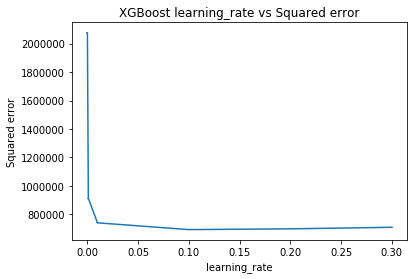

In [ ]:
Audio(sound_file, autoplay=True)

In [62]:
means

array([-2074028.15949577,  -913110.55667849,  -739760.30670164,
        -692115.60366874,  -697472.31728936,  -708416.0222512 ])

In [64]:
params

[{'xgbregressor__learning_rate': 0.0001},
 {'xgbregressor__learning_rate': 0.001},
 {'xgbregressor__learning_rate': 0.01},
 {'xgbregressor__learning_rate': 0.1},
 {'xgbregressor__learning_rate': 0.2},
 {'xgbregressor__learning_rate': 0.3}]